In [1]:
from nnunetv2.run.run_training import get_trainer_from_args
from nnunetv2.run.load_pretrained_weights import load_pretrained_weights

In [2]:
import config as CFG
import torch
from main import make_train_valid_dfs, build_loaders, valid_epoch
import torchio as tio

/home/gridsan/nchutisilp/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
CFG.experiment_name="CLIP_debug_feature_visualization"
CFG.nnUNet['configuration'] = '3d_32x512x512_b2'
CFG.nnUNet['dataset_name_or_id'] = '302'
CFG.nnUNet['fold'] = '2'

trainer = get_trainer_from_args(
    dataset_name_or_id=CFG.nnUNet['dataset_name_or_id'],
    configuration=CFG.nnUNet['configuration'],
    fold=CFG.nnUNet['fold'],
    trainer_name=CFG.nnUNet['trainer_name'],
    plans_identifier=CFG.nnUNet['plans_identifier'],
    device=torch.device('cpu'))
trainer.initialize()
# load_pretrained_weights(trainer.network, '/home/gridsan/nchutisilp/datasets/nnUNet_Datasets/nnUNet_results/Dataset302_Calcium_OCTv2/nnUNetTrainer__nnUNetPlans__3d_32x512x512_b2/fold_2_pretrained_CLIP/checkpoint_best.pth')
# load_pretrained_weights(trainer.network, '/home/gridsan/nchutisilp/projects/OpenAI-CLIP/clip_pretrained_nnUNet.pt')
load_pretrained_weights(trainer.network, '/home/gridsan/nchutisilp/datasets/ModelGenesisOutputs/ModelGenesisNNUNetPretrainingV2_noNorm_correct_orientation/Converted_nnUNet_Genesis_OCT_Best.pt')


Using device: cpu

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################



/home/gridsan/nchutisilp/.local/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


################### Loading pretrained weights from file  /home/gridsan/nchutisilp/datasets/ModelGenesisOutputs/ModelGenesisNNUNetPretrainingV2_noNorm_correct_orientation/Converted_nnUNet_Genesis_OCT_Best.pt ###################


In [4]:
# train_dataframe, valid_dataframe = make_train_valid_dfs()
# valid_dl = build_loaders(dataframe=valid_dataframe, mode='valid')

In [5]:
# torch.cuda.empty_cache()

In [6]:
_ = trainer.network.to(CFG.device)

In [7]:
# for batch in valid_dl:
#     device = CFG.device
#     batch['image1'] = batch['image1'][tio.DATA].permute(0, 1, 4, 3, 2).to(device)
#     batch['image2'] = batch['image2'][tio.DATA].permute(0, 1, 4, 3, 2).to(device)
#     break

In [5]:
# torch.save(batch, 'validation_batch.pth')
batch = torch.load('validation_batch.pth', map_location='cpu')

In [6]:
batch['image1'].shape

torch.Size([16, 1, 32, 512, 512])

In [56]:
trainer.network.eval()
with torch.no_grad():
    with torch.autocast(device_type="cuda", dtype=torch.float16):
        output = trainer.network.encoder(batch['image1'][0:1])
# print(output.shape)

/home/gridsan/nchutisilp/.local/lib/python3.9/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


In [7]:
import matplotlib.pyplot as plt
import torch
import yaml
import numpy as np
import torch.nn.functional as F

# %%
def get_robust_pca(features: torch.Tensor, m: float = 2, remove_first_component=False):
    # features: (N, C)
    # m: a hyperparam controlling how many std dev outside for outliers
    assert len(features.shape) == 2, "features should be (N, C)"
    reduction_mat = torch.pca_lowrank(features, q=3, niter=20)[2]
    colors = features @ reduction_mat
    if remove_first_component:
        colors_min = colors.min(dim=0).values
        colors_max = colors.max(dim=0).values
        tmp_colors = (colors - colors_min) / (colors_max - colors_min)
        fg_mask = tmp_colors[..., 0] < 0.2
        reduction_mat = torch.pca_lowrank(features[fg_mask], q=3, niter=20)[2]
        colors = features @ reduction_mat
    else:
        fg_mask = torch.ones_like(colors[:, 0]).bool()
    d = torch.abs(colors[fg_mask] - torch.median(colors[fg_mask], dim=0).values)
    mdev = torch.median(d, dim=0).values
    s = d / mdev
    try:
        rins = colors[fg_mask][s[:, 0] < m, 0]
        gins = colors[fg_mask][s[:, 1] < m, 1]
        bins = colors[fg_mask][s[:, 2] < m, 2]
        rgb_min = torch.tensor([rins.min(), gins.min(), bins.min()])
        rgb_max = torch.tensor([rins.max(), gins.max(), bins.max()])
    except:
        rins = colors
        gins = colors
        bins = colors
        rgb_min = torch.tensor([rins.min(), gins.min(), bins.min()])
        rgb_max = torch.tensor([rins.max(), gins.max(), bins.max()])

    return reduction_mat, rgb_min.to(reduction_mat), rgb_max.to(reduction_mat)


def get_pca_map_whole_volume(
    feature_map: torch.Tensor,
    img_size,
    interpolation="bicubic",
    return_pca_stats=False,
    pca_stats=None,
    remove_first_component=False,
):
    """
    feature_map: (num_frames, h, w, C) is the feature map of a single image.
    """
    # print(feature_map.shape)
    if feature_map.shape[0] != 1:
        # make it (1, num_frames, h, w, C)
        feature_map = feature_map[None]
    if pca_stats is None:
        reduct_mat, color_min, color_max = get_robust_pca(
            feature_map.reshape(-1, feature_map.shape[-1]),
            remove_first_component=remove_first_component,
        )
    else:
        reduct_mat, color_min, color_max = pca_stats
    pca_color = feature_map @ reduct_mat
    pca_color = (pca_color - color_min) / (color_max - color_min)
    pca_color = pca_color.clamp(0, 1)
    resized_pca_colors = []
    for i in range(pca_color.shape[1]):
        resized_pca_color = F.interpolate(
            pca_color[:, i, :, :, :].permute(0, 3, 1, 2),
            size=img_size,
            mode=interpolation,
        ).permute(0, 2, 3, 1)
        resized_pca_colors.append(resized_pca_color.cpu().numpy().squeeze(0))
    pca_color = np.stack(resized_pca_colors, axis=0)
    if return_pca_stats:
        return pca_color, (reduct_mat, color_min, color_max)
    return pca_color

In [ ]:
for feature in output:
    print(feature.shape)

In [7]:
print(batch['image1'][0].shape)

step = 4
fig, axes = plt.subplots(nrows=1, ncols=batch['image1'][0].shape[1] // step, figsize=(40, 40))
for i_col in range(0, batch['image1'][0].shape[1], step):
    axes[i_col//step].imshow(batch['image1'][0][0, i_col], cmap='gray')
fig.savefig('original_image_for_feature_visualization.pdf')

torch.Size([1, 32, 512, 512])


In [10]:
%matplotlib inline

CFG.experiment_name="CLIP_debug_feature_visualization"
CFG.nnUNet['configuration'] = '3d_32x512x512_b2'
CFG.nnUNet['dataset_name_or_id'] = '302'
CFG.nnUNet['fold'] = '2'

trainer = get_trainer_from_args(
    dataset_name_or_id=CFG.nnUNet['dataset_name_or_id'],
    configuration=CFG.nnUNet['configuration'],
    fold=CFG.nnUNet['fold'],
    trainer_name=CFG.nnUNet['trainer_name'],
    plans_identifier=CFG.nnUNet['plans_identifier'],
    device=torch.device('cpu'))
trainer.initialize()
load_pretrained_weights(trainer.network, '/home/gridsan/nchutisilp/datasets/ModelGenesisOutputs/ModelGenesisNNUNetPretrainingV2_noNorm_correct_orientation/Converted_nnUNet_Genesis_OCT_Best.pt')

_ = trainer.network.to(CFG.device)

for batch_index in range(0,16):
    with torch.no_grad():
        with torch.autocast(device_type="cuda", dtype=torch.float16):
            output = trainer.network.encoder(batch['image1'][batch_index:batch_index + 1])

    for feature_index in range(len(output)):
        feature = output[feature_index]
        feature = get_pca_map_whole_volume(feature.permute(0, 2, 3, 4, 1), feature.shape[-2:], remove_first_component=True)

        step = max(1, feature.shape[0] // 4)

        fig, axes = plt.subplots(nrows=1, ncols=feature.shape[0] // step, figsize=(35, 10))
        for i_col in range(0, feature.shape[0], step):
            axes[i_col//step].imshow(feature[i_col])

        fig.savefig(f'genesis_feature_map_batch{batch_index}_feature{feature_index}.png')        
        plt.close()


In [ ]:
%matplotlib inline
CFG.experiment_name="CLIP_debug_feature_visualization"
CFG.nnUNet['configuration'] = '3d_32x512x512_b2'
CFG.nnUNet['dataset_name_or_id'] = '302'
CFG.nnUNet['fold'] = '2'

feature_index = 5


trainer = get_trainer_from_args(
    dataset_name_or_id=CFG.nnUNet['dataset_name_or_id'],
    configuration=CFG.nnUNet['configuration'],
    fold=CFG.nnUNet['fold'],
    trainer_name=CFG.nnUNet['trainer_name'],
    plans_identifier=CFG.nnUNet['plans_identifier'],
    device=torch.device('cpu'))
trainer.initialize()
load_pretrained_weights(trainer.network, '/home/gridsan/nchutisilp/projects/OpenAI-CLIP/clip_pretrained_nnUNet.pt')
trainer.network.eval()
with torch.no_grad():
    with torch.autocast(device_type="cuda", dtype=torch.float16):
        output = trainer.network.encoder(batch['image1'][0:1])



feature = output[feature_index]
feature = get_pca_map_whole_volume(feature.permute(0, 2, 3, 4, 1), (512, 512))

step = 1
fig, axes = plt.subplots(nrows=1, ncols=feature.shape[0] // step, figsize=(40, 40))
for i_col in range(0, feature.shape[0], step):
    axes[i_col//step].imshow(feature[i_col])


trainer = get_trainer_from_args(
    dataset_name_or_id=CFG.nnUNet['dataset_name_or_id'],
    configuration=CFG.nnUNet['configuration'],
    fold=CFG.nnUNet['fold'],
    trainer_name=CFG.nnUNet['trainer_name'],
    plans_identifier=CFG.nnUNet['plans_identifier'],
    device=torch.device('cpu'))
trainer.initialize()
trainer.network.eval()
with torch.no_grad():
    with torch.autocast(device_type="cuda", dtype=torch.float16):
        output = trainer.network.encoder(batch['image1'][0:1])

feature = output[feature_index]
feature = get_pca_map_whole_volume(feature.permute(0, 2, 3, 4, 1), (512, 512))

step = 1
fig, axes = plt.subplots(nrows=1, ncols=feature.shape[0] // step, figsize=(40, 40))
for i_col in range(0, feature.shape[0], step):
    axes[i_col//step].imshow(feature[i_col])
# fig.savefig('default_feature_map_0.pdf')
# fig.savefig('clip_feature_map_0.pdf')

In [ ]:
from CLIP import CLIPModel

CFG.experiment_name = 'CLIP_debug_nnUnet'
model = CLIPModel()
# model.image_encoder1.load_state_dict(torch)
CLIP_batch = dict()
model.eval()
with torch.no_grad():
    with torch.autocast(device_type="cuda", dtype=torch.float16):
        # CLIP_batch['image1'] = batch['image1'][tio.DATA].permute(0, 1, 4, 3, 2).to(device)
        # CLIP_batch['image2'] = batch['image2'][tio.DATA].permute(0, 1, 4, 3, 2).to(device)
        loss = model(batch, mode="valid", visualize=True)



In [20]:
from CLIP import CLIPModel

CFG.experiment_name = 'CLIP_debug_nnUnet'
model2 = CLIPModel(shared_projector=True, shared_encoder=True)

model1 = CLIPModel()
model1.load_state_dict(torch.load('logs/shared_projector_shared_encoder/best.pt', map_location='cpu'))# model.image_encoder1.load_state_dict(torch)

#load only projector weight to CLIP
# model2.image_projection2 = model1.image_projection2
# model2.image_projection1 = model1.image_projection1

model = model1
CLIP_batch = dict()
model.eval()
with torch.no_grad():
    with torch.autocast(device_type="cuda", dtype=torch.float16):
        # CLIP_batch['image1'] = batch['image1'][tio.DATA].permute(0, 1, 4, 3, 2).to(device)
        # CLIP_batch['image2'] = batch['image2'][tio.DATA].permute(0, 1, 4, 3, 2).to(device)
        image1 = batch["image1"]
        image2 = batch["image2"]

        # Check for NaN values
        masks = torch.isnan(image1) | torch.isnan(image2)
        masks = ~masks.any(dim=(1, 2, 3, 4))
        image1 = image1[masks]
        image2 = image2[masks]

        # Getting Image and Text Features
        visual_features1 = model.image_encoder1.model(image1)
        visual_features2 = model.image_encoder2.model(image2)
        image_features1 = model.image_encoder1(image1)
        image_features2 = model.image_encoder2(image2)

        # Getting Image and Text Embeddings (with same dimension)
        image_embeddings1 = model.image_projection1(image_features1)
        image_embeddings2 = model.image_projection2(image_features2)
        # loss = model(batch, mode="valid", visualize=True)



Using device: cpu

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################



/home/gridsan/nchutisilp/.local/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Using device: cpu

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################



/home/gridsan/nchutisilp/.local/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


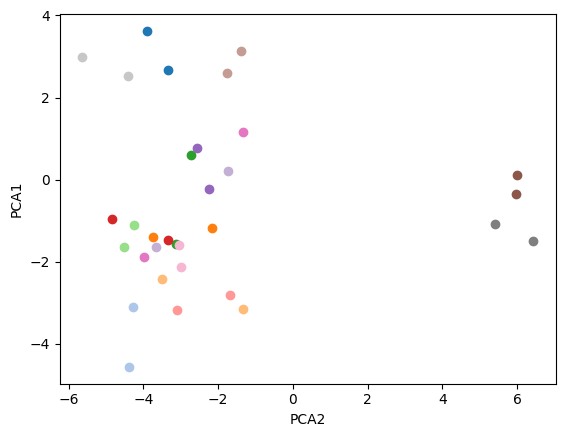

<Figure size 800x800 with 0 Axes>

In [16]:
# torch.save(image_embeddings1, 'image_embeddings1.pth')
# torch.save(image_embeddings2, 'image_embeddings2.pth')

image_embedding_all = torch.cat([image_embeddings1, image_embeddings2], dim=0)
reduction_mat = torch.pca_lowrank(image_embedding_all, q=2, niter=20)[2]
pca_features_all = image_embedding_all @ reduction_mat

# print(reduction_mat.shape, colors.shape)

%matplotlib inline
from matplotlib import colormaps

colors = colormaps['tab20']
total = image_embeddings1.shape[0]
np.random.seed(0)

for i in range(total):
    pair = pca_features_all[[i, i + total]]
    plt.scatter(pair[:, 0], pair[:, 1], color=colors(i))
plt.xlabel("PCA2")
plt.ylabel("PCA1")
plt.figure(figsize=(10, 10), dpi=80)
plt.show()

In [ ]:
# back
clip_real_state_dict = torch.load('logs/shared_projector_shared_encoder/best.pt', map_location='cpu')
clip_nnunet_state_dict = torch.load('clip_pretrained_nnUNet.pt', map_location='cpu')
for w in clip_nnunet_state_dict['network_weights']:
    print(torch.eq(clip_real_state_dict[w.replace('encoder', 'image_encoder1.model')], clip_nnunet_state_dict['network_weights'][w]).all())

In [65]:
%matplotlib inline

for batch_index in range(0,16):
    with torch.no_grad():
        with torch.autocast(device_type="cuda", dtype=torch.float16):
            output1 = model1.image_encoder1.model(batch['image1'][batch_index:batch_index + 1])

    with torch.no_grad():
        with torch.autocast(device_type="cuda", dtype=torch.float16):
            output2 = model2.image_encoder1.model(batch['image1'][batch_index:batch_index + 1])

    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(35, 10))
    step = batch['image1'][batch_index].shape[1] // 4
    for i_col in range(0, batch['image1'][batch_index].shape[1], step):
        axes[i_col//step].imshow(batch['image1'][batch_index][0][i_col], cmap='gray')
    fig.savefig(f'image1_batch{batch_index}.png')
    plt.close()
    for feature_index in range(len(output2)):
        feature = output1[feature_index]
        feature = get_pca_map_whole_volume(feature.permute(0, 2, 3, 4, 1), feature.shape[-2:], remove_first_component=True)

        step = max(1, feature.shape[0] // 4)

        fig, axes = plt.subplots(nrows=1, ncols=feature.shape[0] // step, figsize=(35, 10))
        for i_col in range(0, feature.shape[0], step):
            axes[i_col//step].imshow(feature[i_col])

        fig.savefig(f'clip_feature_map_batch{batch_index}_feature{feature_index}.png')        
        plt.close()
        feature = output2[feature_index]
        feature = get_pca_map_whole_volume(feature.permute(0, 2, 3, 4, 1), feature.shape[-2:], remove_first_component=True)

        fig, axes = plt.subplots(nrows=1, ncols=feature.shape[0] // step, figsize=(35, 10))
        for i_col in range(0, feature.shape[0], step):
            axes[i_col//step].imshow(feature[i_col])

        fig.savefig(f'default_feature_map_batch{batch_index}_feature{feature_index}.png')
        plt.close()